In [1]:
from sklearn.metrics import *

In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.8 MB/s eta 0:00:00


In [3]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 KB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.4 MB/s eta 0:00:00


In [4]:
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE SCHOOL/4월 1주차 - 4차 미니프로젝트/train.csv')

In [7]:
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

df['label'] = df['label'].map(label_dict)

In [8]:
# 2965가 80%
# 2965부터 20%
df_train = df[:2817]
df_valid = df[2817:3262]
df_test = df[3262:]

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

class_names = ['코드','웹','이론','시스템 운영','원격']

# train 데이터셋 준비
df_train_target = df_train.pop('label')
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.values, df_train_target.values))
raw_train_ds = train_dataset.shuffle(len(df_train)).batch(batch_size)
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# validation 데이터셋 준비
df_valid_target = df_valid.pop('label')
valid_dataset = tf.data.Dataset.from_tensor_slices((df_valid.values, df_valid_target.values))
valid_ds = valid_dataset.shuffle(len(df_valid)).batch(batch_size)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

# test 데이터셋
df_test_target = df_test.pop('label')
test_dataset = tf.data.Dataset.from_tensor_slices((df_test.values, df_test_target.values))
test_ds = test_dataset.batch(batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'text: {text_batch.numpy()[i][0].decode("utf-8")}')
    label = label_batch.numpy()[i]
    print(f'label : {label} ({class_names[label]})')

text: shell 실행하면 저런 오류가 출력되는데 어떻게 해결할 수 있을까요?
label : 1 (웹)
text: [실행]
d024155:~/environment $ mysql --user masteradmin --password --host d024155-rds.cvibwlehhtnc.ap-northeast-1.rds.amazonaws.com
Enter password: 
[결과출력문]
ERROR 2002 (HY000): Can't connect to MySQL server on 'd024155-rds.cvibwlehhtnc.ap-northeast-1.rds.amazonaws.com' (115)

[문의사항]
cloud9에서 계속 오류가 나는데 튜터님께서 만들어주신 이후로도 오류가 발생했습니다. 
도와주시면 감사드리겠습니다.
label : 1 (웹)
text: attacker에  첫번째 명령어인
﻿sed -i ‘s/gateway 31.44.7.254/gateway 31.44.7.2/g’ /etc/network/interfaces
입력시 아래와 같은 
결과가 나오는게 맞을까요? 
이상한 특수문자가 이써서..

label : 1 (웹)


In [11]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
text_test = ['케이스 6번만 fail 뜨는데 뭐가 문제인지 모르겠습니다']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  9806 48653   127 35465 19105 84891  9151 41850  9303 11287  9297]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
text_preprocessed

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[   101,   9806,  48653,    127,  35465,  19105,  84891,   9151,
          41850,   9303,  11287,   9297,  17730,  12030,  12508,   9283,
          31401, 118632, 119081,  48345,    102,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0

In [15]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [16]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.12567727 -0.06817002  0.23166017 -0.05115346 -0.03040016  0.3113417
 -0.01056019  0.2368507  -0.35769725  0.18862596  0.00880267 -0.18638094]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.00638242 -0.19056548 -0.18306345 ...  0.39875865  0.04434815
   0.18934736]
 [ 0.12762436 -0.5389756   0.04429924 ...  0.7068449  -0.16766483
   0.21776807]
 [ 0.00745161 -0.59509027 -0.19241863 ...  0.8016621  -0.10311208
   0.35678872]
 ...
 [ 0.05897752 -0.3636411  -0.48533836 ...  0.6358471  -0.17640565
   0.5061946 ]
 [ 0.3912353  -1.1980666  -0.05224615 ...  1.0193409   0.38444698
   0.9166769 ]
 [-0.22197126 -0.85875577 -1.0748733  ...  1.0938904  -0.10571401
   0.4808172 ]]


In [17]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  # 마지막에 softmax classifier를 붙혀주자

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
  
  return tf.keras.Model(text_input, net)

In [18]:
text_test

['케이스 6번만 fail 뜨는데 뭐가 문제인지 모르겠습니다']

In [19]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))

In [20]:
bert_raw_result

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.25711128, 0.18959916, 0.10881513, 0.31518435, 0.12929006]],
      dtype=float32)>

In [21]:
sum([0.15844439, 0.2043202 , 0.25693938, 0.16804315, 0.2122529 ])

1.00000002

In [22]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [23]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [24]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
                         
print(f'Training model with {tfhub_handle_encoder}')

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3


In [25]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

In [26]:
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 3,
                   verbose = 1,
                   restore_best_weights = True)

In [27]:
from keras.backend import clear_session
clear_session()

In [28]:
history = classifier_model.fit(x = train_ds,
                               validation_data=valid_ds,
                               epochs=epochs,
                               callbacks = [es])

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


89/89 [==============================] - 111s 1s/step - loss: 1.1845 - sparse_categorical_accuracy: 0.5126 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.6876
Epoch 2/10
89/89 [==============================] - 90s 1s/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.8214 - val_sparse_categorical_accuracy: 0.7236
Epoch 3/10
89/89 [==============================] - 90s 1s/step - loss: 0.3712 - sparse_categorical_accuracy: 0.8722 - val_loss: 0.9162 - val_sparse_categorical_accuracy: 0.7213
Epoch 4/10
89/89 [==============================] - 90s 1s/step - loss: 0.2461 - sparse_categorical_accuracy: 0.9205 - val_loss: 0.6457 - val_sparse_categorical_accuracy: 0.7978
Epoch 5/10
89/89 [==============================] - 90s 1s/step - loss: 0.1483 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.7910
Epoch 6/10
89/89 [==============================] - 90s 1s/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9702 - v

In [29]:
prediction = classifier_model.predict(test_ds)

14/14 [==============================] - 5s 322ms/step


In [30]:
prediction_idx = []
for i in prediction:
    prediction_idx.append(i.argmax())

In [31]:
len(prediction_idx)

444

In [32]:
len(df_test_target)

444

In [33]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

14/14 [==============================] - 5s 364ms/step - loss: 0.5598 - sparse_categorical_accuracy: 0.8266
Loss: 0.5598139762878418
Accuracy: 0.8265765905380249


In [34]:
history.history

{'loss': [1.1844943761825562,
  0.6311079263687134,
  0.3712318241596222,
  0.2461446225643158,
  0.1482558399438858,
  0.09952829033136368,
  0.07067703455686569],
 'sparse_categorical_accuracy': [0.5126020312309265,
  0.7742279171943665,
  0.8722044825553894,
  0.9204827547073364,
  0.9538516402244568,
  0.9701810479164124,
  0.9776358008384705],
 'val_loss': [0.8704478144645691,
  0.8213710784912109,
  0.9161872863769531,
  0.6457358598709106,
  0.809757649898529,
  0.7844016551971436,
  0.8969837427139282],
 'val_sparse_categorical_accuracy': [0.6876404285430908,
  0.7235954999923706,
  0.7213482856750488,
  0.7977527976036072,
  0.7910112142562866,
  0.8247190713882446,
  0.8224719166755676]}

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


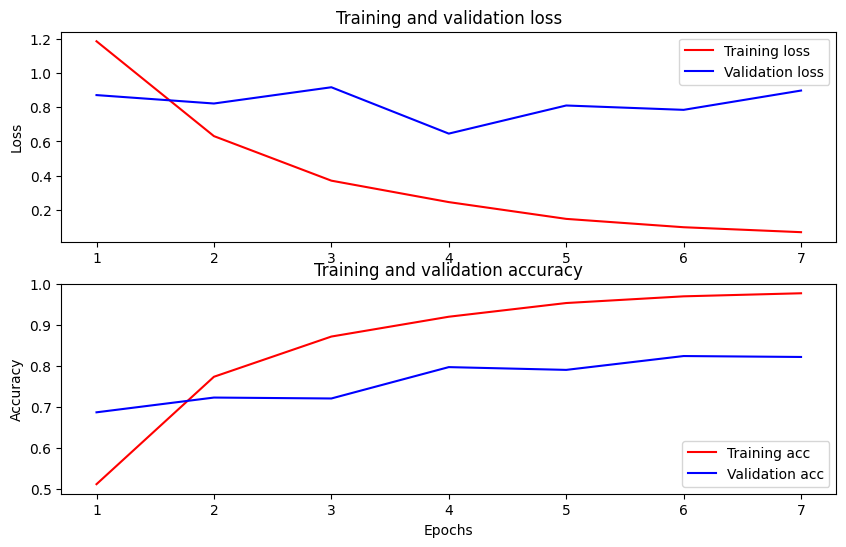

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [36]:
prediction = classifier_model.predict(test_ds)

14/14 [==============================] - 4s 321ms/step


In [37]:
predicted_labels = np.argmax(prediction, axis = 1)

In [38]:
f1 = f1_score(df_test_target, predicted_labels, average='macro')

In [39]:
print(classification_report(df_test_target, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       201
           1       0.80      0.80      0.80        80
           2       0.71      0.66      0.69        89
           3       0.86      0.85      0.85        59
           4       1.00      0.87      0.93        15

    accuracy                           0.83       444
   macro avg       0.85      0.82      0.83       444
weighted avg       0.83      0.83      0.83       444



In [40]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

14/14 [==============================] - 5s 324ms/step - loss: 0.5598 - sparse_categorical_accuracy: 0.8266
Loss: 0.5598139762878418
Accuracy: 0.8265765905380249
